In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import helper
from collections import defaultdict

/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:160: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:181: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [3]:
#root="~/Documents/GitHub/CA_GRN2/results_new_rules/"
#root="~/Documents/GitHub/CA_GRN2/results_testing_saving/"
root="~/scratch/detailed_save/"
#root="~/all_avemaxs/"
season_len = 300
seed_ints = [69904,149796]
metric = "avefits"
num_reps = 5

# NOTE: CAN USE BELOW CODE WITH THE FOLLOWING: 
# avail_metrics = ["avefits","maxfits","beststd","spec_pheno_stds", "pheno_stds", "geno_stds"]
# beststd - how good it could get at biased phenotypic variation, max
# spec_pheno_stds - how good it could get at biased phenotypic variation, mean
# pheno_stds - pheno variation among kids of one parent

xs = []
ys = []
#rules=np.array([22, 126, 146, 154, 82, 86, 18, 118, 122, 70,54,94,30,50,62,110,90,150,102,254])
rules=np.array([22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102])
#Excluded 82 == 154, 146 == 18, 86 == 30, 118 == 62, 254 conceptually == 50
print(len(rules))
for rule in rules:
    vari_maxs, env1_maxs, env2_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps)
    x,y = helper.scatter_value(vari_maxs, env1_maxs, env2_maxs, season_len=300)
    xs.append(x)
    ys.append(y)

15


In [4]:
#Plotting targets
nrows = len(rules)
ncols = 2
scale=2
dev_steps=22
num_cells=22

plotting = False

counter=0
rcounter=0
targets=[]
for i in range(nrows*2):
    if counter % 2 == 0:
        start_pattern = helper.seedID2string(seed_ints[0], num_cells)
        target = helper.rule2targets_wrapped_wstart(int(rules[rcounter]), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
        targets.append(target)
    else:
        start_pattern = helper.seedID2string(seed_ints[1], num_cells)
        target = helper.rule2targets_wrapped_wstart(int(rules[rcounter]), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
        rcounter+=1
        targets.append(target)
    counter+=1

#----------------
if plotting:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * scale, nrows*scale), sharex=True, sharey=True)
    #ax.set_title(f"Rule: {rules[i]}", fontsize=16)

    axs = axs.flatten()
    counter=0
    rcounter=0
    targets=[]
    for i, ax in enumerate(axs):
        if counter % 2 == 0:
            start_pattern = helper.seedID2string(seed_ints[0], num_cells)
            target = helper.rule2targets_wrapped_wstart(int(rules[rcounter]), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
            #print("one",rules[rcounter])
            ax.set_ylabel(rules[rcounter], rotation=90, size='large')
            targets.append(target)
        else:
            start_pattern = helper.seedID2string(seed_ints[1], num_cells)
            target = helper.rule2targets_wrapped_wstart(int(rules[rcounter]), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
            #print("two",rules[rcounter])
            rcounter+=1
            targets.append(target)
        helper.imshow_ca(target,ax=ax)
        counter+=1

    for ax, col in zip(axs, ["T1","T2"]):
        ax.set_title(col)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2519/3190543528.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2519/3190543528.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


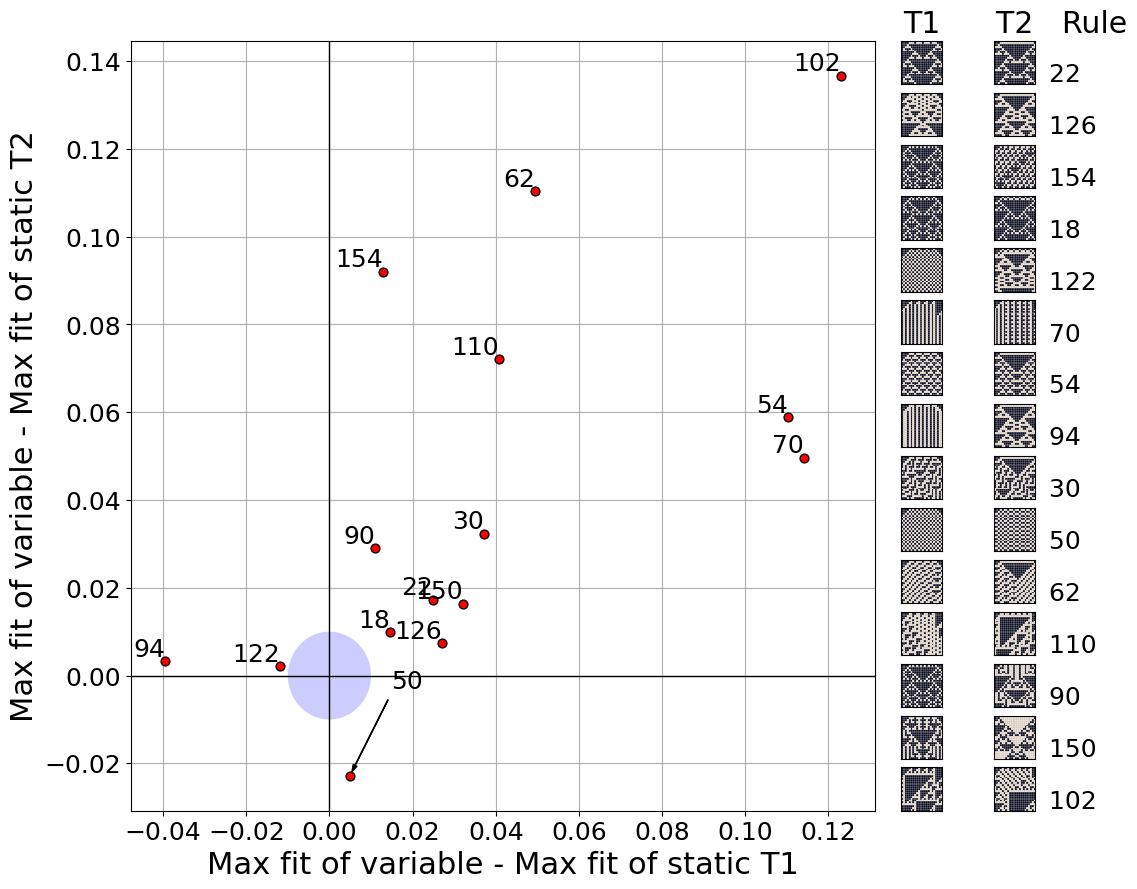

In [5]:
Ts = [
    targets[0::2],
    targets[1::2],
]

#xs,ys=pickle.load(open("2env_scatter.p", "rb"))

#rules_ims=[102,54,62,50,254,30,90,150,94,110]
#rules_scatter=[54,94,30,50,62,110,90,150,102,254]

plt.rcParams["font.size"] = 18

fig = plt.figure(constrained_layout=True, figsize=(18,10))
gs = fig.add_gridspec(len(rules), len(rules), wspace=0.0, hspace=0.2)
ax = fig.add_subplot(gs[:, :8])

helper.main_plt(xs, ys, rules, ax)

for T in [0, 1]:
    for i in range(len(rules)):
        ax = fig.add_subplot(gs[i, 8 + T])
        if i == 0 and T == 0:
            ax.set_title(f"T{T+1}", ha="center")
        if i == 0 and T == 1:
            ax.set_title(f"          T{T+1}   Rule", ha="center")
        if T == 1:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f" {rules[i]}", rotation="horizontal", ha="left")
        helper.imshow_ca(Ts[T][i], ax=ax)

plt.tight_layout()
plt.show()
#plt.savefig("figs/2envinp_scatter.png")

122


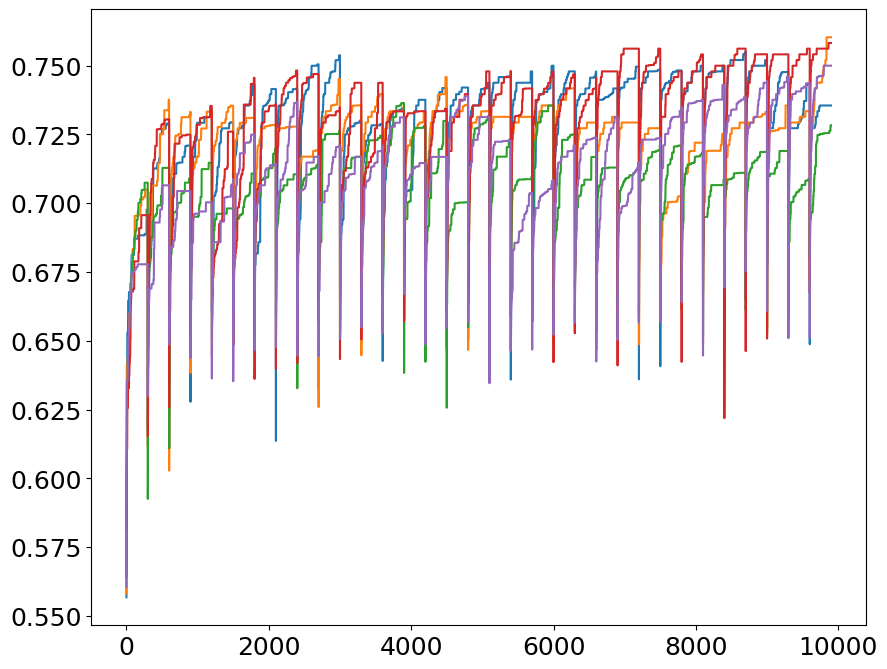

In [15]:
root="~/scratch/detailed_save/mut_blast/"
temprules = [122]
tempmetric = "maxfits"
num_reps = 5
season_len=300
fig = plt.figure(figsize=(10,8))
for rule in temprules:
    print(rule)
    vari_maxs=[np.loadtxt(os.path.expanduser(root+f"stats_{season_len}_{rule}-{rule}_{149796}-{149796}_{i+1}_{tempmetric}.txt")) for i in range(num_reps)]
    for v in vari_maxs:
        plt.plot(v)
    plt.show()


In [43]:
rules

array([ 22, 126, 154,  18, 122,  70,  54,  94,  30,  50,  62, 110,  90,
       150, 102])

In [30]:
#root="~/Documents/GitHub/CA_GRN2/results_testing_saving/"
#root="~/Documents/GitHub/CA_GRN2/results_testing_L1_01_good/"
#root="~/all_avemaxs/"
root="~/scratch/detailed_save/"
root_new=root#"~/scratch/detailed_save/mut_blast/"
season_len = 300
metric = "maxfits"
rule = 18
seed_ints = [69904,149796]
num_reps = 5

vari_maxs=[np.loadtxt(os.path.expanduser(root_new+f"variable/stats_{season_len}_{rule}-{rule}_{69904}-{149796}_{i+1}_{metric}.txt")) for i in range(num_reps)]
vari_maxs=[v[:9899] for v in vari_maxs] #so that it is not 100 gens into a new season



In [31]:
print(rule)

18


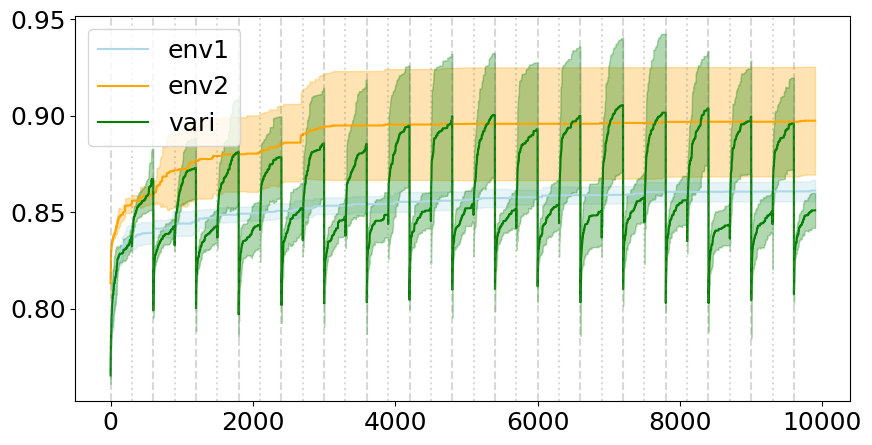

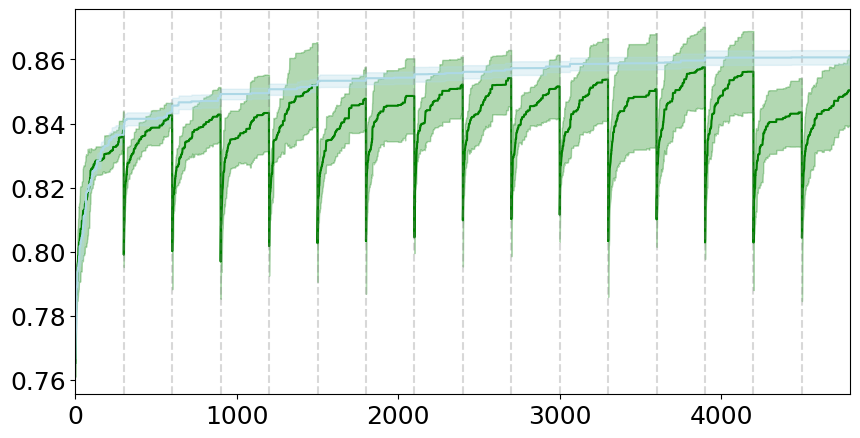

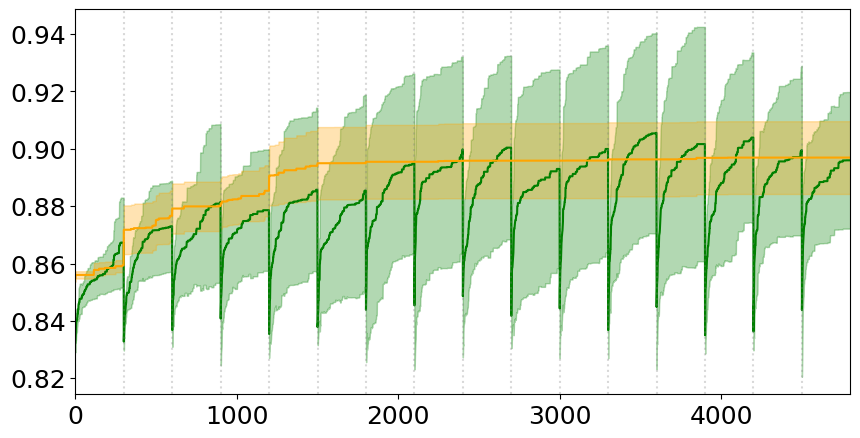

In [37]:
all_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, exprapolate=True)
all_maxs=np.array(all_maxs)
labels=["vari","env1","env2"]
colors = ["green", "lightblue", "orange"]
z_value = 1.96  # For a 95% confidence interval

#plot all variable, together
fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
for i,m in enumerate(all_maxs[1:]):
    mean1 = np.mean(m, axis=0)
    stderr1 = np.std(m, axis=0) / np.sqrt(num_reps)
    ci_upper = mean1 + z_value * stderr1
    ci_lower = mean1 - z_value * stderr1
    ax.fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3, color = colors[1:][i])
    ax.plot(mean1, "-", label=labels[1:][i], color = colors[1:][i])
m=vari_maxs #all_maxs[0]
mean1 = np.mean(m, axis=0)
stderr1 = np.std(m, axis=0) / np.sqrt(num_reps)
ci_upper = mean1 + z_value * stderr1
ci_lower = mean1 - z_value * stderr1
ax.fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3,color=colors[0])
ax.plot(mean1, "-", label= labels[0], color=colors[0])
#ax.set_xlim(1000,1700)
ax.legend()
for j in range(0, len(mean1), season_len):
    if j % (season_len * 2) == 0:
        ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
    else:
        ax.axvline(j, linestyle=":", color="gray", alpha=0.3)

'''
#put together with color
season1, season2, gens1, gens2 = helper.chunker_plotting(mean1, season_len = 300)
season1_std, season2_std, _, _ = helper.chunker_plotting(stderr1, season_len = 300)
fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
for i in range(len(gens1)):
    ax.plot(gens1[i], season1[i],color="C1")
    ax.fill_between(gens1[i], season1[i] - season1_std[i], season1[i] + season1_std[i], alpha=0.3,color="C1")
    ax.plot(gens2[i], season2[i],color="C2")
    ax.fill_between(gens2[i], season2[i] - season2_std[i], season2[i] + season2_std[i], alpha=0.3,color="C2")
for j in range(0, len(mean1), season_len):
    if j % (season_len * 2) == 0:
        ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
    else:
        ax.axvline(j, linestyle=":", color="gray", alpha=0.3)
plt.show()
'''

#chunk it up!
season1, season2, chunked_gens1, chunked_gens2 = helper.chunker_plotting(mean1, season_len = 300)
season1 = np.reshape(season1, (season1.shape[0]*season1.shape[1]))
season2 = np.reshape(season2, (season2.shape[0]*season2.shape[1]))

season1_std, season2_std, _, _ = helper.chunker_plotting(stderr1, season_len = 300)
season1_std = np.reshape(season1_std, (season1_std.shape[0]*season1_std.shape[1]))
season2_std = np.reshape(season2_std, (season2_std.shape[0]*season2_std.shape[1]))

#chunk the statics too
chunked_gens1 = np.array([x for xs in chunked_gens1 for x in xs])
chunked_gens2 = np.array([x for xs in chunked_gens2 for x in xs])

fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
ax.plot(season1,color=colors[0])
ax.fill_between(range(len(season1)), season1 - z_value*season1_std, season1 + z_value*season1_std, alpha=0.3,color=colors[0])
for j in range(0, len(season1), season_len):
    if j % (season_len * 2) == 0:
        ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
    else:
        ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
mean1 = np.mean(all_maxs[1][:, chunked_gens1], axis=0) #all reps, only chunked gens
stderr1 = np.std(all_maxs[1][:, chunked_gens1], axis=0) / np.sqrt(num_reps)
ci_upper = mean1 + z_value * stderr1
ci_lower = mean1 - z_value * stderr1
ax.fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3, color = colors[1])
ax.plot(mean1, "-", label=labels[1], color = colors[1])
plt.xlim(0, len(season1))
#plt.ylim(0.8,0.9)
plt.show()

fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
ax.plot(season2,color=colors[0])
ax.fill_between(range(len(season2)), season2 - z_value*season2_std, season2 + z_value*season2_std, alpha=0.3,color=colors[0])
for j in range(0, len(season2), season_len):
    if j % (season_len * 2) == 0:
        ax.axvline(j, linestyle=":", color="gray", alpha=0.3)
    else:
        ax.axvline(j, linestyle=":", color="gray", alpha=0.3)
mean1 = np.mean(all_maxs[2][:, chunked_gens2], axis=0)
stderr1 = np.std(all_maxs[2][:, chunked_gens2], axis=0) / np.sqrt(num_reps)
ci_upper = mean1 + z_value * stderr1
ci_lower = mean1 - z_value * stderr1
ax.fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3, color = colors[2])
ax.plot(mean1, "-", label=labels[2], color = colors[2])
plt.xlim(0, len(season1))
#plt.ylim(0.9,1)
plt.show()

In [21]:
root = "~/Documents/GitHub/CA_GRN2/results_testing_saving/"
avail_metrics = ["avefits","maxfits","beststd","spec_pheno_stds", "pheno_stds","geno_stds"]
metric = avail_metrics[5]
rules = [rule,rule]
output=[np.loadtxt(os.path.expanduser(root+f"stats_{season_len}_{rules[0]}-{rules[1]}_{seed_ints[0]}-{seed_ints[1]}_{i+1}_{metric}.txt")) for i in range(1)]

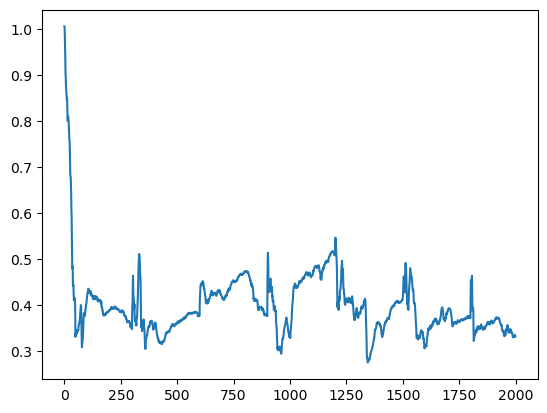

In [22]:
plt.plot(output[0])